# Custom model and Transform

This notebook contains the simple examples of custom model and Transform that can be added to the ETNA framework.

**Table of Contents**

* [What is Transform and how it works](#chapter1)  
* [Custom Transform](#chapter2)
* [Custom Model](#chapter3)

In [1]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.transforms import DateFlagsTransform, LinearTrendTransform

import warnings
warnings.filterwarnings("ignore")

### 1. What is Transform and how it works <a class="anchor" id="chapter1"></a>

Our library works with the spacial data structure TSDataset. So, before starting, we need to convert the classical DataFrame to TSDataset.

In [2]:
df = pd.read_csv("data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq='D')

ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


Let's look at the original view of data

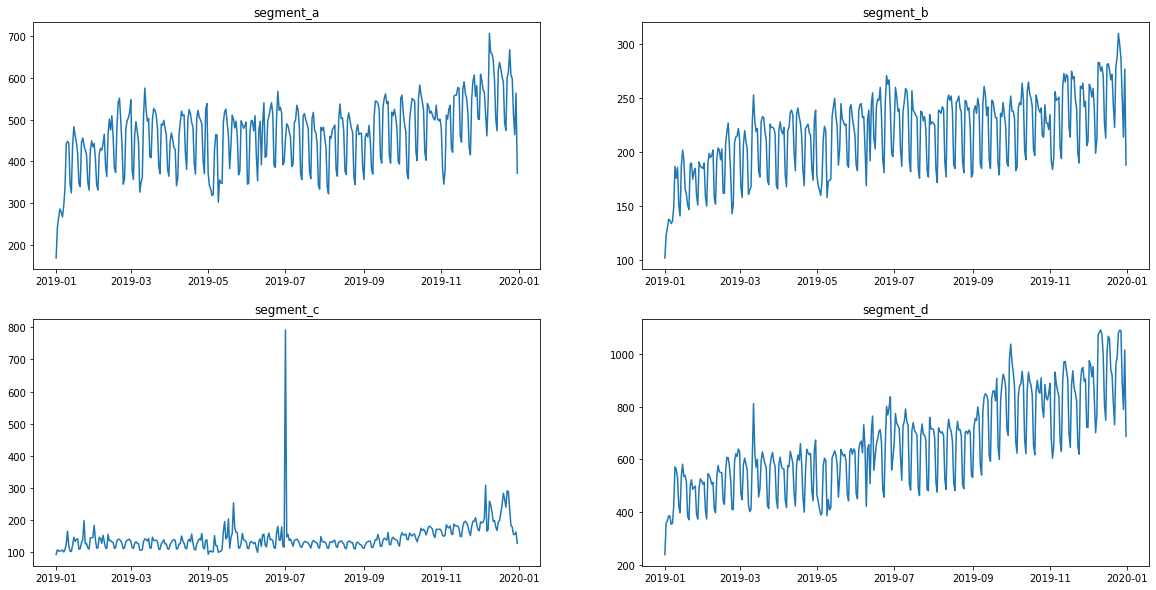

In [3]:
ts.plot()

Transform is the manipulation of data to extract new features or update created ones. 

In ETNA, Transforms can change column values ​​or add new ones. 

For example:

*   DateFlagsTransform - 
adds columns with information about the date (day number, is the day a weekend, etc.) .
*   LinearTrendTransform - subtracts a linear trend from the series (changes it).



In [4]:
dates = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
detrend = LinearTrendTransform(in_column="target")

ts.fit_transform([dates, detrend])

ts.head(3)

segment                      segment_a                                  \
feature    dateflag_day_number_in_week dateflag_is_weekend      target   
timestamp                                                                
2019-01-01                           1               False -227.971480   
2019-01-02                           2               False -155.343065   
2019-01-03                           3               False -131.714650   

segment                      segment_b                                 \
feature    dateflag_day_number_in_week dateflag_is_weekend     target   
timestamp                                                               
2019-01-01                           1               False -78.034404   
2019-01-02                           2               False -57.239544   
2019-01-03                           3               False -50.444684   

segment                      segment_c                                 \
feature    dateflag_day_number_in_week dateflag_is_weekend     target   
timestamp                                                               
2019-01-01                           1               False -19.560207   
2019-01-02                           2               False  -4.740449   
2019-01-03                           3               False  -8.920692   

segment                      segment_d                                  
feature    dateflag_day_number_in_week dateflag_is_weekend      target  
timestamp                                                               
2019-01-01                           1               False -183.693061  
2019-01-02                           2               False  -65.005495  
2019-01-03                           3               False  -58.317930

In addition to the appearance of a new column, the values ​​in the target column have changed. This can be seen from the graphs.

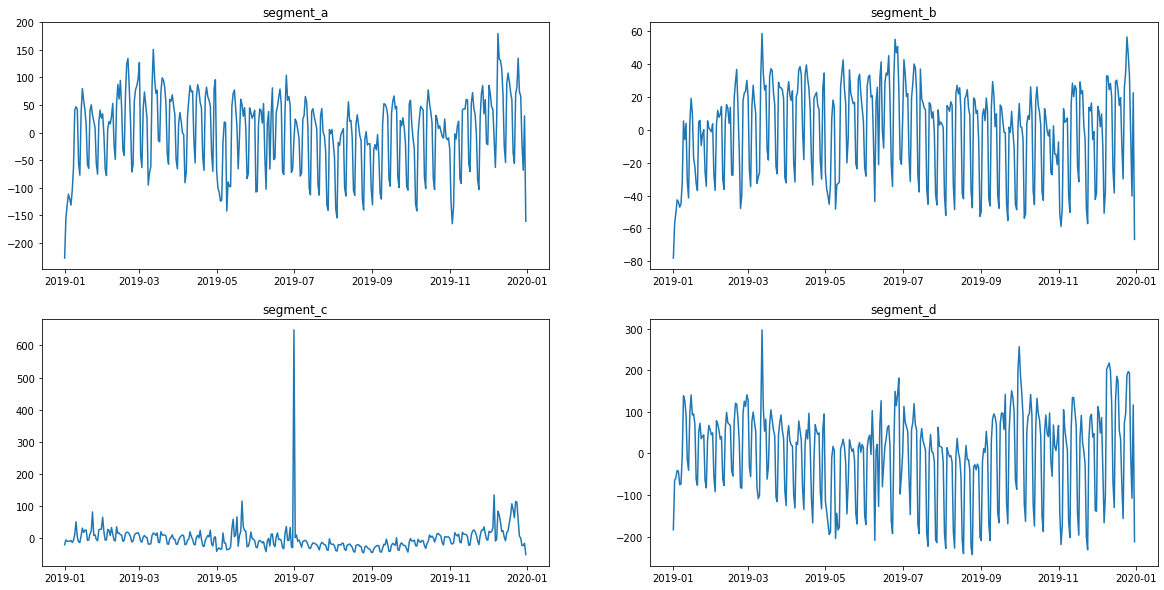

In [5]:
ts.plot()

In [6]:
ts.inverse_transform()
ts.head(3)

segment                      segment_a                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False  170.0   
2019-01-02                           2               False  243.0   
2019-01-03                           3               False  267.0   

segment                      segment_b                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False  102.0   
2019-01-02                           2               False  123.0   
2019-01-03                           3               False  130.0   

segment                      segment_c                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False   92.0   
2019-01-02                           2               False  107.0   
2019-01-03                           3               False  103.0   

segment                      segment_d                             
feature    dateflag_day_number_in_week dateflag_is_weekend target  
timestamp                                                          
2019-01-01                           1               False  238.0  
2019-01-02                           2               False  358.0  
2019-01-03                           3               False  366.0

Now the data is back in its original form

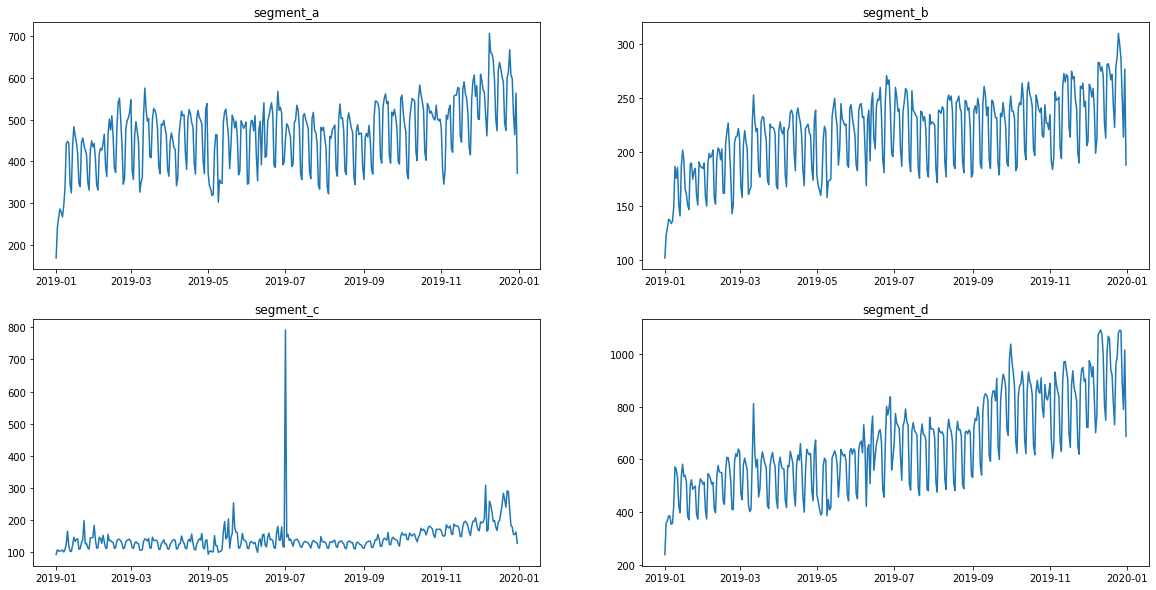

In [7]:
ts.plot()

### 2. Custom Transform <a class="anchor" id="chapter2"></a>

Let's define custom Transform.

Consider a Transform that sets bounds at the top and bottom - FloorCeilTransform

ETNA use PerSegmentWrapper, so it is enough to describe the transformation for one segment and then apply it.


Any Transform inherits from the base class.

In [8]:
from etna.transforms.base import PerSegmentWrapper
from etna.transforms.base import Transform

In [9]:
# Сlass for processing one segment.
class _OneSegmentFloorCeilTransform(Transform):

    # Сonstructor with the name of the column to which the transformation will be applied.
    def __init__(self, in_column: str, floor: float, ceil: float):
        """
        Create instance of _OneSegmentLinearTrendBaseTransform.

        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound 
        """
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil

    # Provide the necessary training. For example calculates the coefficients of a linear trend.
    # In this case, we calculate the indices that need to be changed 
    # and remember the old values ​​for inverse transform.
    def fit(self, df: pd.DataFrame) -> "_OneSegmentFloorCeilTransform":
        """
        Calculate the indices that need to be changed.

        Returns
        -------
        self
        """
        target_column = df[self.in_column]

        self.floor_indices = target_column < self.floor
        self.floor_values = target_column[self.floor_indices]

        self.ceil_indices = target_column > self.ceil
        self.ceil_values = target_column[self.ceil_indices]

        return self

    # Apply changes.
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Drive the value to the interval [floor, ceil].

        Parameters
        ----------
        df:
            DataFrame to transform

        Returns
        -------
        transformed series
        """
        result_df = df.copy()
        result_df[self.in_column].iloc[self.floor_indices] = self.floor
        result_df[self.in_column].iloc[self.ceil_indices] = self.ceil


        return result_df

    # Do it all in one action. Base class requirement.
    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)

    # Returns back ​​changed values. 
    def inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Inverse transformation for transform. Return back changed values.

        Parameters
        ----------
        df:
            data to transform

        Returns
        -------
        pd.DataFrame
            reconstructed data
        """
        result = df.copy()
        result[self.in_column][self.floor_indices] = self.floor_values
        result[self.in_column][self.ceil_indices] = self.ceil_values

        return result


Now we can define class, which will work with the entire dataset, applying a transform(*_OneSegmentFloorCeilTransform*) to each segment. 

This functionality is provided by *PerSegmentWrapper*.

In [10]:
class FloorCeilTransform(PerSegmentWrapper):
    """Transform that truncate values ​​to an interval [ceil, floor]"""

    def __init__(self, in_column: str, floor: float, ceil: float):
        """Create instance of FloorCeilTransform.
        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound 
        """
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil
        super().__init__(
            transform=_OneSegmentFloorCeilTransform(
                in_column=self.in_column, floor=self.floor, ceil=self.ceil
            )
        )


Lets take a closer look.

This is what the original data looks like.

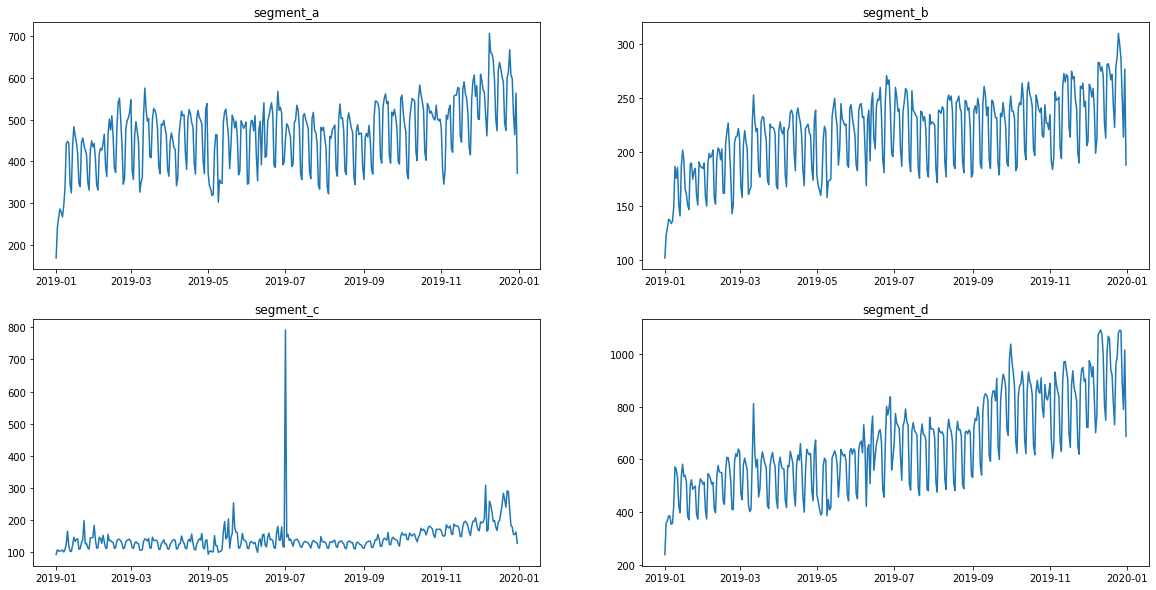

In [11]:
ts.plot()

In [12]:
bounds = FloorCeilTransform(in_column="target", floor=150, ceil=600)

ts.fit_transform([bounds])

The values ​​are now limited. Let's see how it looks

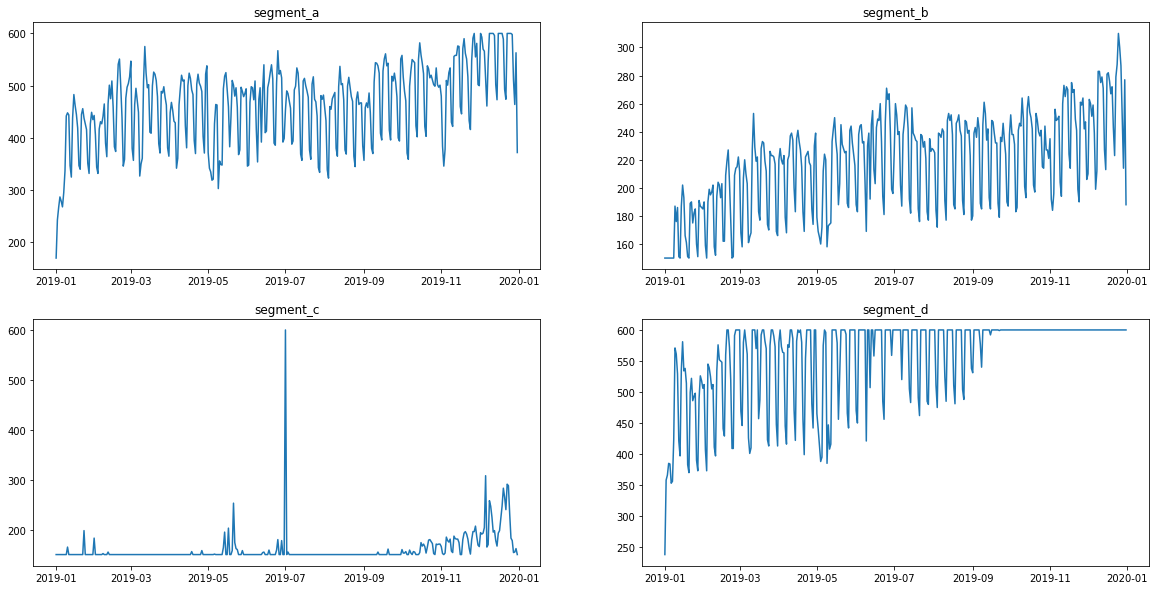

In [13]:
ts.plot()

Returning to the original values

In [14]:
ts.inverse_transform()

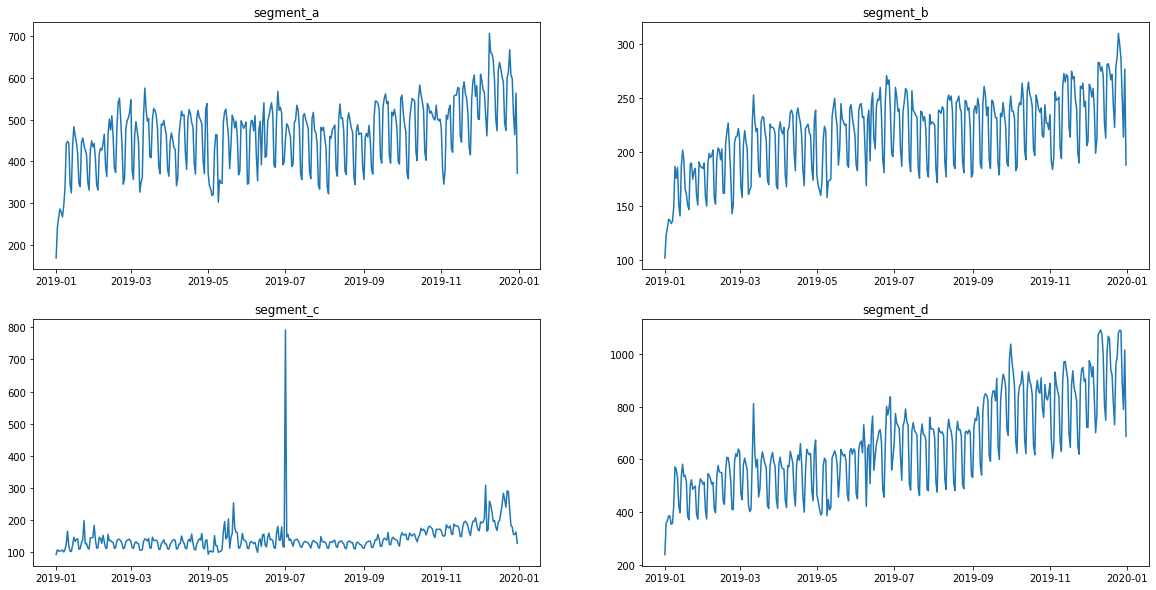

In [15]:
ts.plot()

Everything seems to be working correctly. Remember to write the necessary [tests](https://github.com/tinkoff-ai/etna-ts/tree/master/tests) before adding a new transform to the library.

### 3. Custom Model <a class="anchor" id="chapter3"></a>

In [16]:
!pip install lightgbm

You should consider upgrading via the '/root/.cache/pypoetry/virtualenvs/etna-ts-kue528zj-py3.8/bin/python -m pip install --upgrade pip' command.


if the required module is not in the library, you should add it to the poetry file.

In [17]:
from lightgbm import LGBMRegressor
from etna.datasets.tsdataset import TSDataset
from etna.models.base import Model
from etna.models.base import PerSegmentModel

If you could not find a suitable model among the [ready-made ones]("https://github.com/tinkoff-ai/etna-ts/tree/master/etna/models"), then you can create your own.


There are two ways for using models.

*   One model for enire dataset
*   One model for each segment

We need 2 classes for this options. 



In [18]:
# Inner class, which contains simple fit and predict methods. 
# We can wrap it up to work with TSDataset and specialize it in one of two types of training.
class _LGBMModel:
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.model=LGBMRegressor(
            boosting_type=boosting_type,
            num_leaves=num_leaves,
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            **kwargs
        )

    def fit(self, df: pd.DataFrame):
        features = df.drop(columns=["timestamp", "target"])
        target = df["target"]
        self.model.fit(X=features, y=target)
        return self

    def predict(self, df: pd.DataFrame):
        features = df.drop(columns=["timestamp", "target"])
        pred = self.model.predict(features)
        return pred

One model for each segment. Base class - *PerSegmentModel*. 

All methods are described in the base class. All that remains is to initialize.

In [19]:
class LGBMModelPerSegment(PerSegmentModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        model = _LGBMModel(
                boosting_type=boosting_type,
                num_leaves=num_leaves,
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                **kwargs
            )
        super(LGBMModelPerSegment, self).__init__(base_model=model)

One model for enire dataset. Base class - *Model*

In [20]:
class LGBMModelMultiSegment(Model):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        super(LGBMModelMultiSegment, self).__init__()
        self._base_model=_LGBMModel(
            boosting_type=boosting_type,
            num_leaves=num_leaves,
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            **kwargs
        )

    def fit(self, ts: TSDataset):
        # Now we have to deal with TSDataset, so small changes are required to get raw data.
        df = ts.to_pandas(flatten=True)
        df = df.dropna()
        df = df.drop(columns="segment")
        self._base_model.fit(df=df)
        return self

    def forecast(self, ts: TSDataset):
        result_list = list()
        # Collect our new df using self._forecast_segment from base class. 
        for segment in ts.segments:
            segment_predict = self._forecast_segment(self._base_model, segment, ts)
            result_list.append(segment_predict)

        result_df = pd.concat(result_list, ignore_index=True)
        result_df = result_df.set_index(["timestamp", "segment"])

        df = ts.to_pandas(flatten=True)
        df = df.set_index(["timestamp", "segment"])
        # There are Nuns in future. So we replace them with the predicted values.
        df = df.combine_first(result_df).reset_index()

        df = TSDataset.to_dataset(df)

        # Works implace.
        ts.df = df

        # Remove unnecessary changes.
        ts.inverse_transform()
        
        return ts

Train our model

In [21]:
HORIZON = 31

train_ts, test_ts = ts.train_test_split(train_start='2019-01-01',
                                        train_end='2019-11-30',
                                        test_start='2019-12-01',
                                        test_end='2019-12-31')

In [22]:
from etna.transforms import MeanTransform, LagTransform, LogTransform, \
    SegmentEncoderTransform, DateFlagsTransform, LinearTrendTransform

log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             year_number=True,
                             special_days_in_week=[5, 6],
                             out_column="dateflag")
mean30 = MeanTransform(in_column="target", window=30, out_postfix="_mean30")

In [23]:
train_ts.fit_transform([log, trend, lags, d_flags, seg, mean30])

In [24]:
model = LGBMModelMultiSegment()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

Let's see the results

In [25]:
from etna.analysis import plot_forecast

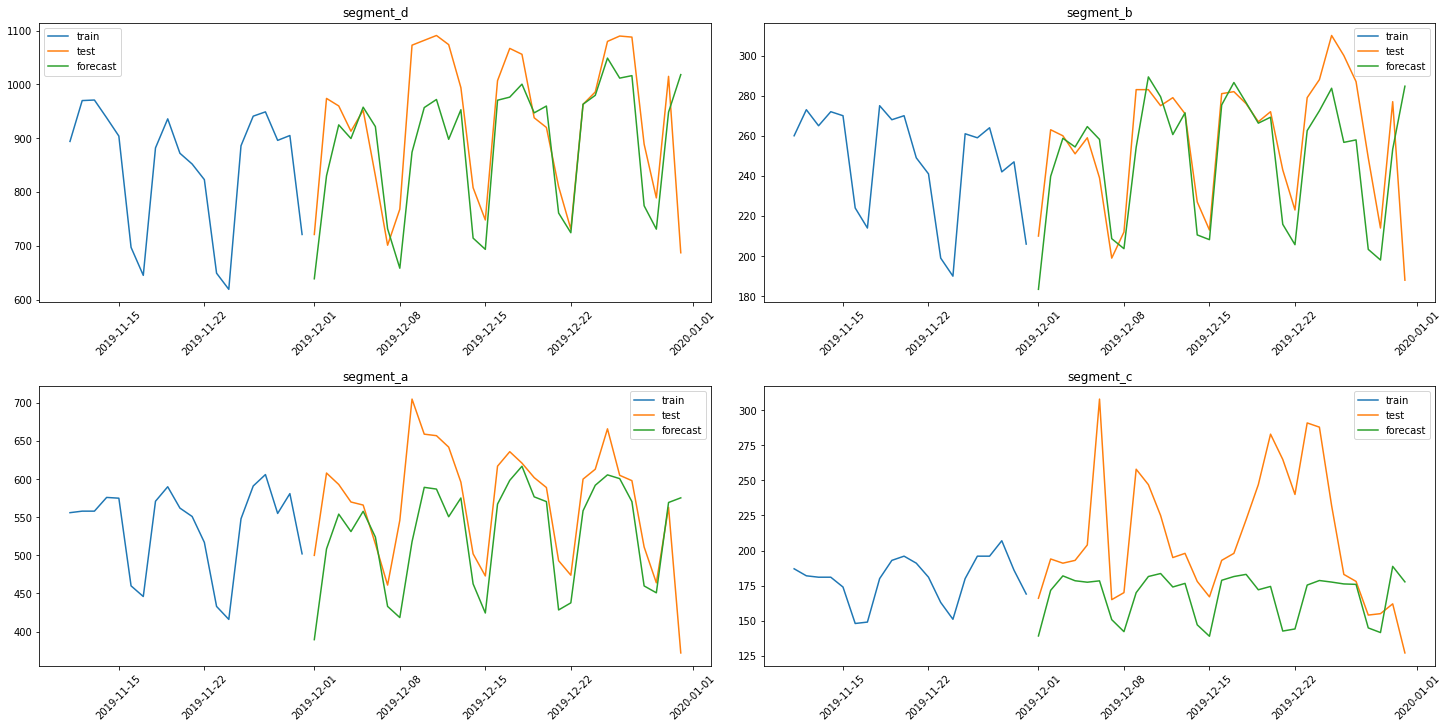

In [26]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)


This way you can specialize your task with ETNA or even add new features to the library. Don't forget to write the necessary tests and documentation. Good luck !